Pipeline Test
--
Test and benchmarking for the harmonization pipeline.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import torch
from src.datasets.dublin.config import config as dublin_config
from src.training.config import config as train_config
from src.datasets.tools.dataloaders import get_dataloaders
from src.datasets.tools.create_dataset import create_dataset
from src.training.train import train
from src.datasets.tools.harmonization_mapping import HarmonizationMapping
from src.evaluation.harmonize import harmonize
import matplotlib.pyplot as plt
import matplotlib
from src.datasets.tools.transforms import Corruption
from src.datasets.tools.metrics import create_kde
from IPython.display import Image

## Harmonize via direct overlap with target

In [2]:
config = {
    'dataset': dublin_config,
    'train': train_config
}
config['dataset']['tqdm'] = True # disable tqdm output in notebook
config['train']['tqdm'] = True # disable tqdm output in notebook

hm = HarmonizationMapping(
    config['dataset']['scans_path'],
    config['dataset']['target_scan'],
    config['dataset']['harmonized_path'],
    create_new=config['dataset']['create_new'])

hm.print_mapping()
n_size = config['train']['neighborhood_size']
print(f"Running with {config['dataset']['workers']} cores")
print(f"Found GPU {config['train']['device']}")
print(f"Using {config['train']['num_gpus']} GPUs")

Final Mapping:
9: 1.0
14: 9.0
1: 1.0
Running with 8 cores
Found GPU cuda:0
Using 1 GPUs


### Build Dataset

In [3]:
create_dataset(hm, config['dataset'])

Creating dataset...
Generating Class Weights
Created dataset in 34.08808732032776 seconds


### Train model

In [4]:
dataloaders = get_dataloaders(config)
training_dataloaders = {k:v for k,v in dataloaders.items() if k != "eval"}

In [5]:
# Visualize Test Set Performance
model, path = train(training_dataloaders, config)

/home/david/bin/python/intensity/src/results/5
train: 3036
test: 759


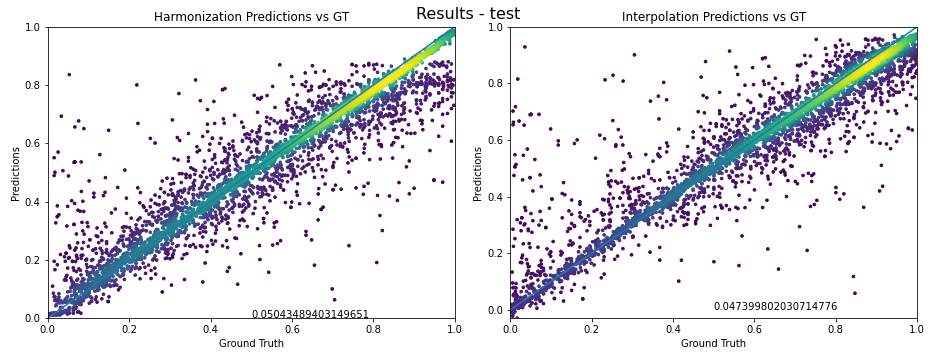

In [6]:
Image(filename=f"../../results/{n_size}/val_kde_{n_size}.png")
# best 0.05854 by removing regularization, igroup_size=0.01, group_sample_size=500, epochs=~25, n_size=5

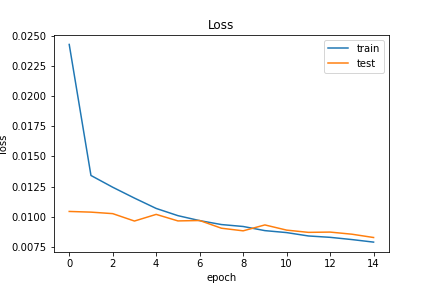

In [7]:
Image(filename=f"../../results/{n_size}/loss.png")

### Harmonize the scan

In [8]:
harmonize(model, config['dataset']['scans_path'] / "9.npy", 1, config, save=True)

Scan 9 Harmonize MAE: 0.021233993493361577


array([[ 3.17149785e+05,  2.33177038e+05, -7.55860000e+01, ...,
        -9.12098957e-01,  7.33610306e-02,  9.00000000e+00],
       [ 3.17149083e+05,  2.33269974e+05, -5.93820000e+01, ...,
        -8.97862620e-01,  1.57345912e-02,  9.00000000e+00],
       [ 3.17149197e+05,  2.33270096e+05, -5.94010000e+01, ...,
        -8.97862620e-01,  1.57345912e-02,  9.00000000e+00],
       ...,
       [ 3.16034645e+05,  2.34669418e+05,  1.29920000e+01, ...,
        -3.03361194e-01,  3.52834711e-01,  9.00000000e+00],
       [ 3.16034645e+05,  2.34669424e+05,  1.32590000e+01, ...,
        -2.88985683e-01,  7.44530430e-02,  9.00000000e+00],
       [ 3.16034633e+05,  2.34669418e+05,  1.35280000e+01, ...,
        -2.93789356e-01,  1.74892169e-02,  9.00000000e+00]])

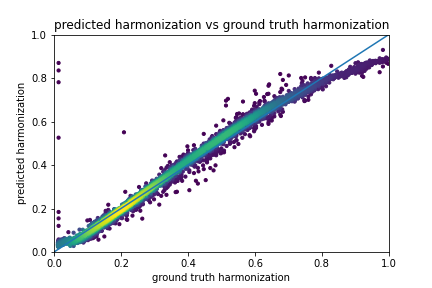

In [9]:
Image(filename=config['dataset']['harmonization_plots_path'] / "9-1_harmonization.png")

# Harmonize via indirect overlap with target
Not all scans in the collection will overlap with the target, but they can be harmonized by using the previously harmonized source scans as targets. This step can be challenging if there is a large amount of noise in the prediction. This can make it difficult to recover the correct transformation.

In [10]:
hm.add_harmonized_scan_path(9)
hm.incr_stage(9)
create_dataset(hm, config['dataset'])

Creating dataset...
Generating Class Weights
Created dataset in 34.76650786399841 seconds


In [11]:
dataloaders = get_dataloaders(config)
training_dataloaders = {k:v for k,v in dataloaders.items() if k != "eval"}
model, path = train(training_dataloaders, config)

/home/david/bin/python/intensity/src/results/5
train: 3036
test: 759


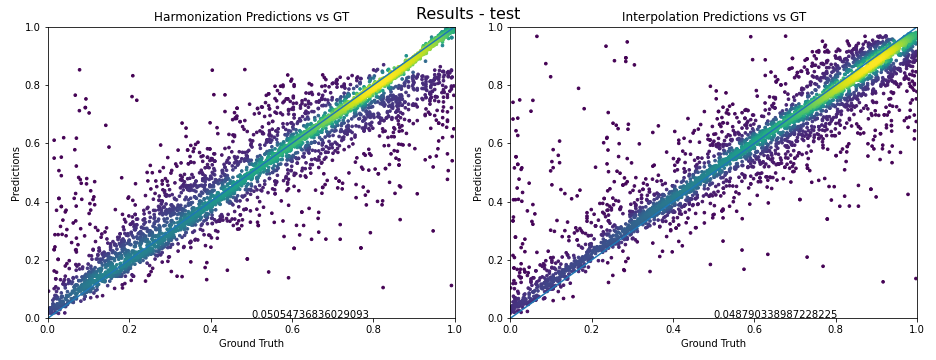

In [12]:
Image(filename=f"../../results/{n_size}/val_kde_{n_size}.png")

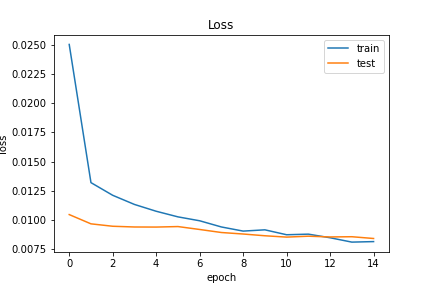

In [13]:
Image(filename=f"../../results/{n_size}/loss.png")

In [14]:
harmonize(model, config['dataset']['scans_path'] / "14.npy", 9, config, save=True)

Scan 14 Harmonize MAE: 0.05163673078942006


array([[ 3.16266358e+05,  2.35846347e+05, -6.29470000e+01, ...,
         4.86693114e-01,  3.88558166e-03,  1.40000000e+01],
       [ 3.16266277e+05,  2.35846485e+05, -6.28480000e+01, ...,
         4.80796810e-01,  7.99422803e-04,  1.40000000e+01],
       [ 3.16266195e+05,  2.35846624e+05, -6.27360000e+01, ...,
        -4.54247826e-01,  2.99027943e-03,  1.40000000e+01],
       ...,
       [ 3.16305708e+05,  2.35870908e+05,  1.07340000e+01, ...,
         1.33294531e-01,  3.42075777e-02,  1.40000000e+01],
       [ 3.16306139e+05,  2.35869971e+05,  1.24110000e+01, ...,
        -3.02431376e-01,  9.43394611e-03,  1.40000000e+01],
       [ 3.16306135e+05,  2.35869953e+05,  1.27160000e+01, ...,
         3.00334165e-01,  5.08688052e-02,  1.40000000e+01]])

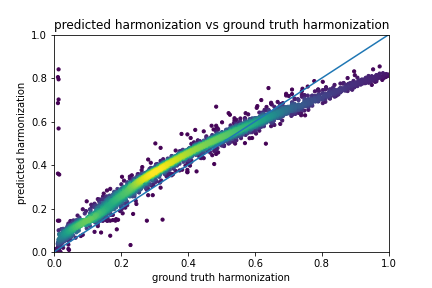

In [15]:
Image(filename=config['dataset']['harmonization_plots_path'] / "14-9_harmonization.png")

### Visualize Results

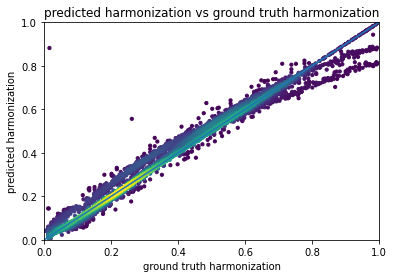

Corrupted MAE:  0.3030592323080916
Harmonized MAE:  0.02234229081878405


In [16]:
## Visualize the Scans
original_scans = np.concatenate(([np.load(f) for f in config['dataset']['scans_path'].glob("*.npy")]), axis=0)
sample = np.random.choice(len(original_scans), 100000)
original_scans = original_scans[sample]
harmonized_scans = np.concatenate(([np.load(f) for f in config['dataset']['harmonized_path'].glob("*.npy")]), axis=0)
harmonized_scans = harmonized_scans[sample]
corrupt = Corruption(**config['dataset'])
not_target = original_scans[original_scans[:, 8] != 1]
target = original_scans[original_scans[:, 8] == 1]
corrupted_scans = corrupt(not_target)[1:,]
corrupted_scans = np.concatenate((target, corrupted_scans))

create_kde(original_scans[:, 3], harmonized_scans[:, 3],
           xlabel="ground truth harmonization", 
           ylabel="predicted harmonization",
           output_path=None)

mae = np.mean(np.abs(original_scans[:, 3] - corrupted_scans[:, 3]))
print("Corrupted MAE: ", mae)
mae = np.mean(np.abs(original_scans[:, 3] - harmonized_scans[:, 3]))
print("Harmonized MAE: ", mae)

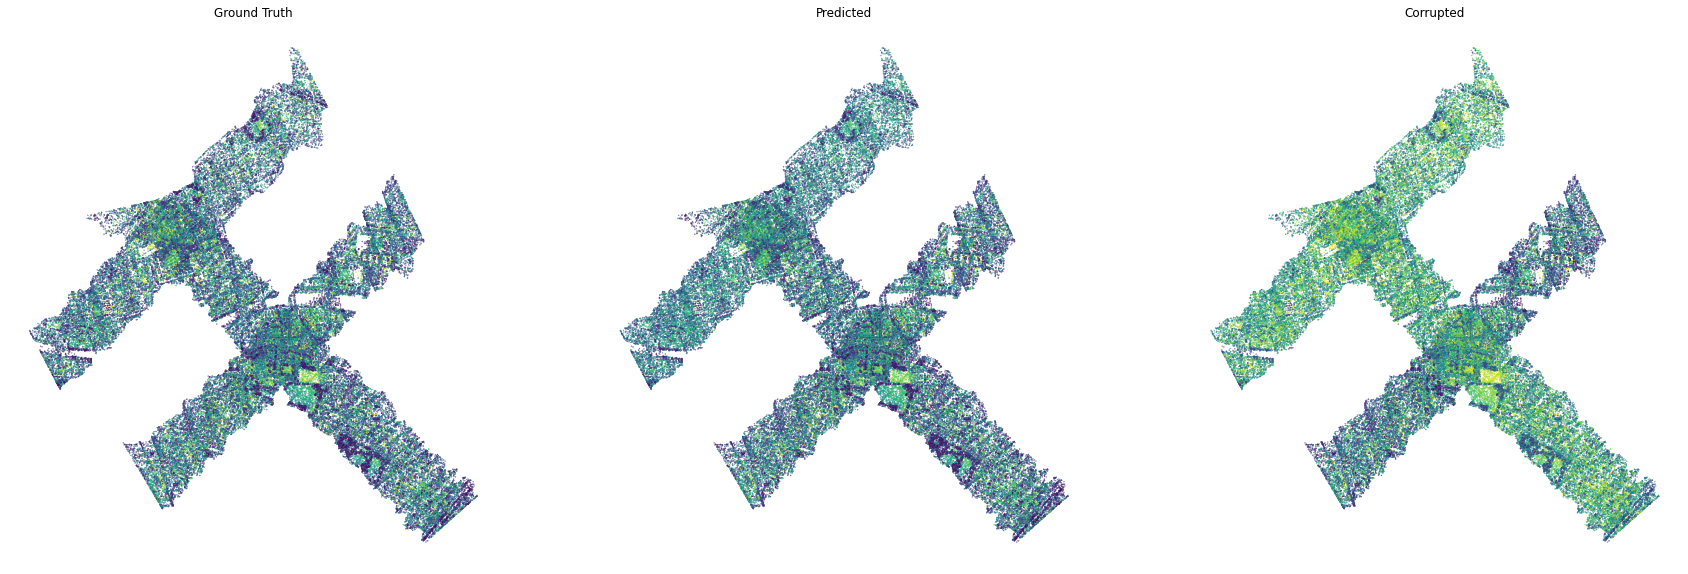

In [17]:
# Figure Sizes
matplotlib.rcParams['figure.figsize'] = [30, 10]

# Plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.scatter(original_scans[:, 0], original_scans[:, 1], c=original_scans[:, 3], s=0.1, vmin=0, vmax=1)
ax1.set_title("Ground Truth")
ax1.axis('off')
ax2.scatter(harmonized_scans[:, 0], harmonized_scans[:, 1], c=harmonized_scans[:, 3], s=0.1, vmin=0, vmax=1)
ax2.set_title("Predicted")
ax2.axis('off')
ax3.scatter(corrupted_scans[:, 0], corrupted_scans[:, 1], c=corrupted_scans[:, 3], s=0.1, vmin=0, vmax=1)
ax3.set_title("Corrupted")
ax3.axis('off')
plt.show()